In [1]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import lightgbm as lgb

# Load & Preprocess Data

In [2]:
# Read data
data = pd.read_pickle('20231108_Dataset.pkl')
data.index.names = ['Date']
data.head()

,transformer_load,radiation,windspeed_10m,windspeed_100m,windspeed_squall,nedu_e1a,nedu_e1b,nedu_e1c,nedu_e2a,nedu_e2b,nedu_e3a,nedu_e3b,nedu_e3c,nedu_e3d,nedu_e4a
Date,,,,,,,,,,,,,,,
2021-04-02 10:15:00+00:00,0.314834,2362538.0,7.087363,8.304909,11.329289,0.000023,0.000017,0.000013,0.000029,0.000025,0.000045,0.000045,0.000045,0.000045,0.0
2021-04-02 10:30:00+00:00,0.455148,2395208.0,7.169058,8.406696,11.468938,0.000022,0.000016,0.000012,0.000029,0.000024,0.000044,0.000044,0.000044,0.000044,0.0
2021-04-02 10:45:00+00:00,0.492845,2427878.0,7.250822,8.508593,11.608627,0.000022,0.000015,0.000011,0.000028,0.000024,0.000043,0.000043,0.000043,0.000043,0.0
2021-04-02 11:00:00+00:00,0.479581,2460548.0,7.332652,8.610595,11.748355,0.000021,0.000014,0.000010,0.000028,0.000024,0.000043,0.000043,0.000043,0.000043,0.0
2021-04-02 11:15:00+00:00,0.512740,2471373.5,7.532573,8.868861,12.003352,0.000020,0.000013,0.000010,0.000028,0.000024,0.000043,0.000043,0.000043,0.000043,0.0


In [3]:
# Check rows with missing values
missing_values_rows = data[data.isnull().any(axis=1)]

# Handle missing values by performing linear interpolation only for wind speeds
data['windspeed_10m'] = data['windspeed_10m'].interpolate(method='linear')
data['windspeed_100m'] = data['windspeed_100m'].interpolate(method='linear')
data['windspeed_squall'] = data['windspeed_squall'].interpolate(method='linear')

# Set radiation values to zero for the rows that had missing values
data.loc[missing_values_rows.index, 'radiation'] = 0

# Drop duplicates
data.drop_duplicates(inplace=True)

# Replace the heavy outlier from the dataset where the transformer load is 2.14
data['transformer_load'] = data['transformer_load'].replace(data['transformer_load'].max(), 
                                                            data['transformer_load'].nlargest(2).iloc[-1])

In [4]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data

data = create_features(data)

In [5]:
def add_lags(data):
    """ 
    Create lagged features of the target variable.
    """
    target_map = data['transformer_load'].to_dict()
    data['lag1'] = (data.index - pd.Timedelta('2 days')).map(target_map)
    data['lag2'] = (data.index - pd.Timedelta('3 days')).map(target_map)
    data['lag3'] = (data.index - pd.Timedelta('7 days')).map(target_map)
    return data

data = add_lags(data)

# Train Forecasting Model

In [6]:
# Initial hyperparameters
lgb_params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'seed': 42,
    'learning_rate': 0.1,
    'num_leaves': 16,
    'max_depth': -1,
    'min_gain_to_split': 0,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'force_col_wise': 'true'
}

In [7]:
# Retrain on all data
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'transformer_load'

X_all = data[FEATURES]
y_all = data[TARGET]
train_data = lgb.Dataset(data[FEATURES], label=data[TARGET])

In [8]:
# Training models for each quantile
quantiles = [0.05, 0.5, 0.95]
models = {}

for quantile in quantiles:
    print(f"Training model for quantile: {quantile}")
    lgb_params['alpha'] = quantile
    model = lgb.train(lgb_params,
                      train_data, 
                      num_boost_round=400,
                      valid_sets=[train_data], 
                      callbacks=[lgb.early_stopping(stopping_rounds=40)]
                      )
    models[quantile] = model

Training model for quantile: 0.05
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 90122, number of used features: 9
[LightGBM] [Info] Start training from score 0.165445


c:\Users\Maxpo\Documents\GitHub\congestion-predictive-modelling\.venv\lib\site-packages\lightgbm\callback.py:294: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


Training model for quantile: 0.5
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 90122, number of used features: 9
[LightGBM] [Info] Start training from score 0.363002
Training model for quantile: 0.95
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 90122, number of used features: 9
[LightGBM] [Info] Start training from score 0.822339


# Short-term Forecasting Inference

In [9]:
# Create future dataframe 
future = pd.date_range(data.index.max(), data.index.max() + pd.Timedelta('2 days'), freq=data.index.to_series().diff().min())
future_data = pd.DataFrame(index=future)
future_data['isFuture'] = True
data['isFuture'] = False
data_and_future = pd.concat([data, future_data])
data_and_future = create_features(data_and_future)
data_and_future = add_lags(data_and_future)

In [10]:
# Predict the next 48 hours
data_and_future['lower_pred'] = models[0.05].predict(data_and_future[FEATURES])
data_and_future['pred'] = models[0.5].predict(data_and_future[FEATURES])
data_and_future['upper_pred'] = models[0.95].predict(data_and_future[FEATURES])

In [11]:
days_15 = 15 * 96
data_and_future = data_and_future[-days_15:-1]

# Splitting the data into known and future datasets
df_history = data_and_future[data_and_future['isFuture'] == False]
df_future = data_and_future[data_and_future['isFuture'] == True]

# Create a figure with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Plotting known data - both actual and predicted quantiles
fig.add_trace(go.Scatter(x=df_history.index, y=df_history['transformer_load'], 
                         mode='lines', name='Actual Load (History)', line=dict(color='blue')), secondary_y=False)

fig.add_trace(go.Scatter(x=df_history.index, y=df_history['pred'], 
                         mode='lines', name='Predicted Load (History)', line=dict(color='red')), secondary_y=False)

fig.add_trace(go.Scatter(x=df_history.index, y=df_history['lower_pred'], mode='lines', line=dict(width=0),showlegend=False))

fig.add_trace(go.Scatter(x=df_history.index, y=df_history['upper_pred'], mode='lines', line=dict(width=0), fill='tonexty',
                         fillcolor='rgba(255, 0, 0, 0.2)', name='90% confidence interval (History)'))

# Plotting future predictions quantiles
fig.add_trace(go.Scatter(x=df_future.index[1:], y=df_future['pred'][1:], 
                         mode='lines', name='Predicted Load (Future)', line=dict(color='green')), secondary_y=False)

fig.add_trace(go.Scatter(x=df_future.index, y=df_future['lower_pred'], mode='lines', line=dict(width=0),showlegend=False))

fig.add_trace(go.Scatter(x=df_future.index, y=df_future['upper_pred'], mode='lines', line=dict(width=0), fill='tonexty',
                         fillcolor='rgba(0, 255, 0, 0.2)', name='90% confidence interval (Future)'))

# Update plot layout
fig.update_layout(
        title={
            'text': f'<b>{"Short-term Forecasting of Transformer Load Last 15 Days + 2 Days Ahead"}<b>',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 20, 'color': 'black', 'family': "Arial, sans-serif"}
        },
 
        xaxis_title='Date',
        yaxis_title='Transformer Load',
        hovermode="x unified"
    )

fig.show()

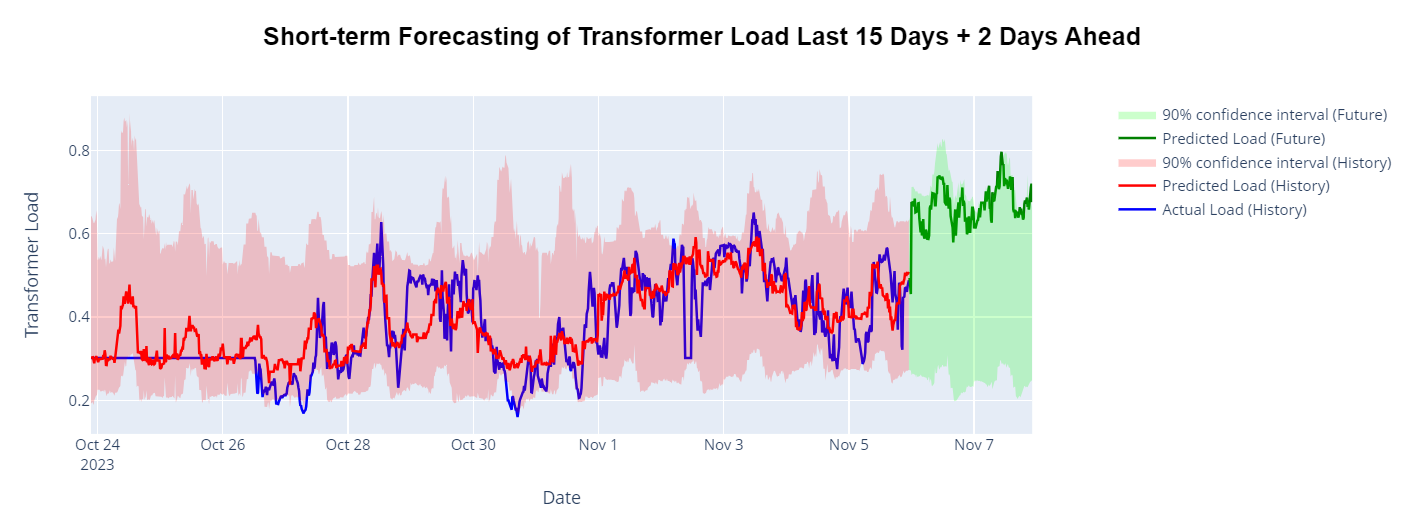